In [2]:
!pip install emoji

In [3]:
import pandas as pd
from tqdm import tqdm

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import emoji

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

In [5]:
base_path = '/content/drive/My Drive/Data/wassa_data/'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
classes = ['anger', 'joy', 'sadness', 'fear']

class_mapping = {}
for idx, name in enumerate(classes):
    class_mapping[name] = idx 
no_classes = len(classes)

In [8]:
cols = ['tweet', 'tweettype']

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:

stop = stopwords.words('english')

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [12]:
!pip install Unidecode

In [13]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [14]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [15]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [16]:
def load_dataset(directory, ending, threshold = 0, testing = False):

    df_list = []

    for emotion in classes:
        file_name = f'{base_path}{directory}/{emotion}{ending}'
        df = pd.read_csv(file_name, delimiter='\t')
        
        if not testing:
            df = df[df['score'] > threshold]
        
        df = df[cols]
        
        df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        df['tweet'] = df['tweet'].apply(clean_text)        
        df['tweettype'] = df['tweettype'].apply(lambda x : class_mapping[x])        

        df_list.append(df)

    df = pd.concat(df_list)
    df = df.rename(columns = {'tweet' : 'text', 'tweettype' : 'label'})
    print('Distribution of data: ')
    print(df['label'].value_counts())
    
    labels = df['label'].values
    
    dataset = build_dataset(df)
    
    return dataset, labels

In [17]:
# Training
threshold = 0

directory = 'training'
ending = '-ratings-0to1.train.txt'

train_dataset,_ = load_dataset(directory, ending, threshold = threshold)

Distribution of data: 
3    1147
0     857
1     823
2     786
Name: label, dtype: int64


In [18]:
# Validation

directory = 'validation'
ending = '-ratings-0to1.dev.gold.txt'

val_dataset,_ = load_dataset(directory, ending)

Distribution of data: 
3    110
0     84
1     79
2     74
Name: label, dtype: int64


In [19]:
# Testing

directory = 'testing'
ending = '-ratings-0to1.test.target.txt'

test_dataset, y_test = load_dataset(directory, ending, testing = True)

Distribution of data: 
3    995
0    760
1    714
2    673
Name: label, dtype: int64


In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [21]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [23]:
model = tf.keras.Sequential([
    encoder,
    
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                              output_dim=64, mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(no_classes)
]) 

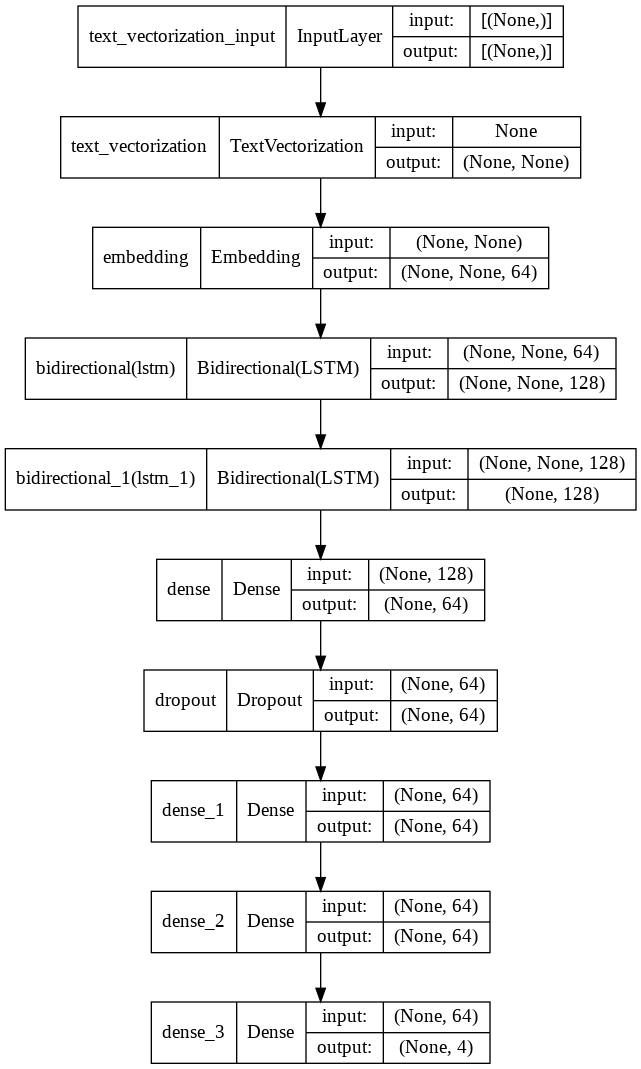

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, to_file='LSTM-only.png')

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  verbose=1, patience=10,
                                                  restore_best_weights=True)

In [27]:
history = model.fit(train_dataset, epochs = 50,
                    validation_data=val_dataset)

Epoch 1/50
29/29 [==============================] - 24s 307ms/step - loss: 1.3860 - accuracy: 0.2854 - val_loss: 1.3853 - val_accuracy: 0.3170
Epoch 2/50
29/29 [==============================] - 4s 125ms/step - loss: 1.3847 - accuracy: 0.3175 - val_loss: 1.3840 - val_accuracy: 0.3170
Epoch 3/50
29/29 [==============================] - 4s 126ms/step - loss: 1.3831 - accuracy: 0.3172 - val_loss: 1.3821 - val_accuracy: 0.3170
Epoch 4/50
29/29 [==============================] - 4s 127ms/step - loss: 1.3815 - accuracy: 0.3175 - val_loss: 1.3802 - val_accuracy: 0.3170
Epoch 5/50
29/29 [==============================] - 4s 131ms/step - loss: 1.3789 - accuracy: 0.3175 - val_loss: 1.3770 - val_accuracy: 0.3170
Epoch 6/50
29/29 [==============================] - 4s 129ms/step - loss: 1.3756 - accuracy: 0.3172 - val_loss: 1.3730 - val_accuracy: 0.3170
Epoch 7/50
29/29 [==============================] - 4s 131ms/step - loss: 1.3678 - accuracy: 0.3230 - val_loss: 1.3636 - val_accuracy: 0.3199
Epoch

### Printing the history parameters

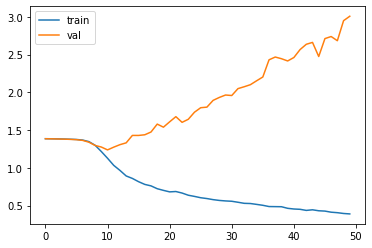

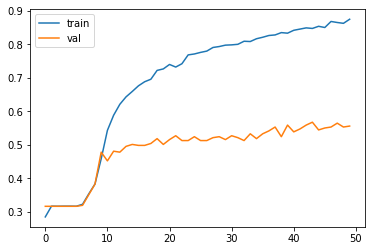

In [28]:
plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Evaluation against test

In [29]:
model.evaluate(test_dataset)

25/25 [==============================] - 1s 39ms/step - loss: 2.9949 - accuracy: 0.5315


[2.994931936264038, 0.5315085649490356]

In [30]:
pred = model.predict(test_dataset)

In [31]:
pred_idx = []
target_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))
    target_idx.append(y_test[i])

100%|██████████| 3142/3142 [00:00<00:00, 263955.44it/s]


In [32]:
print(classification_report(target_idx, pred_idx, target_names=classes))

              precision    recall  f1-score   support

       anger       0.58      0.58      0.58       760
         joy       0.68      0.64      0.66       714
     sadness       0.35      0.28      0.31       673
        fear       0.50      0.58      0.54       995

    accuracy                           0.53      3142
   macro avg       0.53      0.52      0.52      3142
weighted avg       0.53      0.53      0.53      3142



In [33]:
print(confusion_matrix(target_idx, pred_idx))

[[442  35  91 192]
 [ 39 456  71 148]
 [186  53 190 244]
 [ 93 124 196 582]]
